In [60]:
from rdkit import Chem
import pandas as pd
from pathlib import Path
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, MolSentence, sentences2vec, DfVec
from gensim.models import word2vec
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
base_path = Path().cwd().joinpath('content/datasets/')
train_df = pd.read_csv(base_path.joinpath('train_II.csv'))
test_df = pd.read_csv(base_path.joinpath('test_II.csv'))

In [3]:
train_df[["Chemical Id", "Assay Id"]] = train_df.Id.str.split(
    ";", expand=True
)
train_df.drop("Id", axis=1, inplace=True)
train_df = train_df[["Assay Id", "Chemical Id", "Expected"]]

In [4]:
train_df.head()

,Assay Id,Chemical Id,Expected
0,1644,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O,2
1,2451,CCCCCCCCC(=O)C,2
2,1384,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2
3,16,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl,2
4,1856,[Na+].[I-],2


In [5]:
train_df['molecules'] = train_df['Chemical Id'].apply(lambda smile: Chem.MolFromSmiles(smile))

[05:14:24] Explicit valence for atom # 1 Si, 8, is greater than permitted
[05:14:25] Explicit valence for atom # 1 Si, 8, is greater than permitted
[05:14:26] Explicit valence for atom # 1 Si, 8, is greater than permitted
[05:14:27] Explicit valence for atom # 1 Si, 8, is greater than permitted
[05:14:27] Explicit valence for atom # 1 Si, 8, is greater than permitted
[05:14:28] Explicit valence for atom # 1 Si, 8, is greater than permitted


In [6]:
train_df.head()

,Assay Id,Chemical Id,Expected,molecules
0,1644,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc33e0>
1,2451,CCCCCCCCC(=O)C,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3370>
2,1384,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3450>
3,16,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3300>
4,1856,[Na+].[I-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc2f10>


In [7]:
train_df.isna().sum()

Assay Id       0
Chemical Id    0
Expected       0
molecules      6
dtype: int64

In [8]:
len(train_df)

75383

In [9]:
train_df.dropna(inplace=True)

In [10]:
train_df.isna().sum()

Assay Id       0
Chemical Id    0
Expected       0
molecules      0
dtype: int64

In [11]:
train_df.reset_index(drop=True, inplace=True)

In [12]:
pretrained_model = word2vec.Word2Vec.load('model_300dim.pkl')

In [13]:
train_df['sentence'] = train_df['molecules'].apply(lambda mol: MolSentence(mol2alt_sentence(mol,radius=1)))

In [14]:
train_df.head()

,Assay Id,Chemical Id,Expected,molecules,sentence
0,1644,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc33e0>,"(3218693969, 951226070, 3218693969, 951226070,..."
1,2451,CCCCCCCCC(=O)C,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3370>,"(2246728737, 3542456614, 2245384272, 117312591..."
2,1384,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3450>,"(2246728737, 3542456614, 2245384272, 117312591..."
3,16,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3300>,"(2968968094, 3402594617, 2968968094, 280384864..."
4,1856,[Na+].[I-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc2f10>,"(3737048253, 319173395)"


In [15]:
train_df['vectors'] = [DfVec(mol_vector) for mol_vector in sentences2vec(train_df['sentence'], model=pretrained_model, unseen='UNK')]

In [19]:
train_df.head()

,Assay Id,Chemical Id,Expected,molecules,sentence,vectors
0,1644,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc33e0>,"(3218693969, 951226070, 3218693969, 951226070,...","(300,) dimensional vector"
1,2451,CCCCCCCCC(=O)C,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3370>,"(2246728737, 3542456614, 2245384272, 117312591...","(300,) dimensional vector"
2,1384,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3450>,"(2246728737, 3542456614, 2245384272, 117312591...","(300,) dimensional vector"
3,16,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl,2,<rdkit.Chem.rdchem.Mol object at 0x19bfc3300>,"(2968968094, 3402594617, 2968968094, 280384864...","(300,) dimensional vector"
4,1856,[Na+].[I-],2,<rdkit.Chem.rdchem.Mol object at 0x19bfc2f10>,"(3737048253, 319173395)","(300,) dimensional vector"


In [31]:
COLUMNS = [f'MV{i}' for i in range(0, 300)]

molecular_vectors = np.array([mv.vec for mv in train_df['vectors']])
mol_vec_df = pd.DataFrame(data=molecular_vectors, columns=COLUMNS)
mol_vec_df.insert(0, 'Assay Id', train_df['Assay Id'])
mol_vec_df['Expected'] = train_df['Expected']
mol_vec_df.head()

,Assay Id,MV0,MV1,MV2,MV3,MV4,MV5,MV6,MV7,MV8,...,MV291,MV292,MV293,MV294,MV295,MV296,MV297,MV298,MV299,Expected
0,1644,0.591556,0.436794,-2.616474,5.393537,0.979889,1.760543,-8.516331,0.634881,8.672752,...,3.835511,10.874360,2.934474,-2.489406,-2.592273,-4.072971,-1.010019,-6.477407,0.750421,2
1,2451,-1.387351,-0.650103,-1.308442,-0.534801,4.614061,0.907463,-6.503389,-1.544066,2.970018,...,3.197913,5.954277,1.360025,-3.836096,-1.468281,0.407472,-4.784484,-6.204209,-3.584467,2
2,1384,0.057016,-5.191211,-0.658686,-0.642940,10.475833,4.291732,-19.384228,-1.689491,4.949928,...,2.139539,16.158161,0.729103,-9.222128,-5.543818,2.537033,-14.175414,-11.747466,-5.981764,2
3,16,1.559935,-3.572063,-1.491086,3.473112,-0.838103,2.379557,-7.592896,-1.499726,5.498289,...,7.029467,4.817788,-2.289021,-4.723467,-1.145345,-1.126720,-2.132176,-6.254750,-0.356743,2
4,1856,-0.060041,0.155101,0.073155,0.180541,0.421257,-0.185311,-0.516440,0.324106,0.047974,...,0.042580,-0.797013,-0.323537,0.432830,-0.738765,-0.222924,0.272511,-0.600159,0.432861,2


In [35]:
mol_vec_df.to_csv('train_molvec_data.csv', index=False)

In [16]:
test_df[["Chemical Id", "Assay Id"]] = test_df.x.str.split(";", expand=True)
test_df.drop("x", axis=1, inplace=True)
test_df = test_df[["Assay Id", "Chemical Id"]]

In [17]:
test_df['molecules'] = test_df['Chemical Id'].apply(lambda smile: Chem.MolFromSmiles(smile))

In [18]:
test_df.isna().sum()

Assay Id       0
Chemical Id    0
molecules      0
dtype: int64

In [20]:
test_df['sentence'] = test_df['molecules'].apply(lambda mol: MolSentence(mol2alt_sentence(mol,radius=1)))

In [21]:
test_df['vectors'] = [DfVec(mol_vector) for mol_vector in sentences2vec(test_df['sentence'], model=pretrained_model, unseen='UNK')]

In [22]:
test_df.head()

,Assay Id,Chemical Id,molecules,sentence,vectors
0,1682,CC1=CC(=C(C=C1)C(C)(C)C)O,<rdkit.Chem.rdchem.Mol object at 0x1a9a4b300>,"(2246728737, 422715066, 3217380708, 3207567135...","(300,) dimensional vector"
1,1656,CCS(=O)(=O)C1=C(N=CC=C1)S(=O)(=O)NC(=O)NC2=NC(...,<rdkit.Chem.rdchem.Mol object at 0x1a9a4b4c0>,"(2246728737, 3542456614, 2245384272, 178229190...","(300,) dimensional vector"
2,36,CC1=NC2=CC=CC=C2N1C3CC4CCC(C3)N4CCC5(CCN(CC5)C...,<rdkit.Chem.rdchem.Mol object at 0x1a9a4b530>,"(2246728737, 422715066, 3217380708, 829754261,...","(300,) dimensional vector"
3,1850,CC1=CC(=O)[N-]S(=O)(=O)O1.[K+],<rdkit.Chem.rdchem.Mol object at 0x1a9a4b5a0>,"(2246728737, 422715066, 3217380708, 3661288325...","(300,) dimensional vector"
4,30,CCC(C)(C)C(=O)O[C@H]1C[C@H](C=C2[C@H]1[C@H]([C...,<rdkit.Chem.rdchem.Mol object at 0x1a9a4b610>,"(2246728737, 3542456614, 2245384272, 150576976...","(300,) dimensional vector"


In [36]:
molecular_vectors = np.array([mv.vec for mv in test_df['vectors']])
mol_vec_df = pd.DataFrame(data=molecular_vectors, columns=COLUMNS)
mol_vec_df.insert(0, 'Assay Id', test_df['Assay Id'])
mol_vec_df.head()

,Assay Id,MV0,MV1,MV2,MV3,MV4,MV5,MV6,MV7,MV8,...,MV290,MV291,MV292,MV293,MV294,MV295,MV296,MV297,MV298,MV299
0,1682,0.594200,1.089280,-1.363318,2.377262,1.464866,0.371191,-6.059753,0.101892,3.868654,...,-0.938850,2.852365,4.955368,-0.641309,-3.365838,-1.881012,-2.443057,-2.199804,-6.663648,-2.183817
1,1656,2.071164,-5.903744,-1.911758,5.981367,2.007313,-0.135413,-11.257625,0.037847,8.810589,...,1.290284,8.588354,12.169148,-2.063678,-9.252829,-3.912638,-6.905687,-2.095550,-12.356855,-4.284906
2,36,3.513798,-10.650757,-2.338746,11.947106,-7.020576,-1.278095,-20.097008,3.868305,14.147479,...,-2.648430,21.444168,15.451662,-2.483602,-18.042824,-7.744145,-12.428687,-7.628102,-21.449327,-3.476709
3,1850,3.318751,-1.376666,-3.216670,-0.402242,0.336080,0.124505,-4.069031,0.839070,-0.885285,...,-0.575894,3.989857,-0.158101,-1.802653,-4.841865,-2.714195,-3.040305,-3.154216,-4.182100,-0.138847
4,30,-1.795259,-6.074874,-5.024946,1.376536,-0.354517,-10.956933,-12.585599,3.022550,4.726954,...,-2.153061,15.212841,5.397811,-2.250856,-13.275173,-15.389323,-9.747753,-6.150456,-18.290964,1.317636


In [37]:
mol_vec_df.to_csv('test_molvec_data.csv', index=False)

In [48]:
train_dataset = pd.read_csv(Path('train_molvec_data.csv'))
test_dataset = pd.read_csv(Path('test_molvec_data.csv'))

In [14]:
pd.set_option('display.max_rows',10)

In [72]:
y_train = train_dataset.loc[:, 'Expected']
X_train = train_dataset.drop('Expected', axis=1)

In [63]:
# COLUMNS = [f'MV{i}' for i in range(0, 300)]
# assay_ids = X_train.loc[:, 'Assay Id']
# X_train.drop('Assay Id', axis=1, inplace=True)
# sds = MinMaxScaler()
# scaled_x = sds.fit_transform(X_train)
# X_train = pd.DataFrame(data=scaled_x, columns=COLUMNS)
# X_train.insert(0, 'Assay Id', assay_ids)
# X_train

,Assay Id,MV0,MV1,MV2,MV3,MV4,MV5,MV6,MV7,MV8,MV9,MV10,MV11,MV12,MV13,MV14,MV15,MV16,MV17,MV18,MV19,MV20,MV21,MV22,MV23,MV24,MV25,MV26,MV27,MV28,MV29,MV30,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,...,MV260,MV261,MV262,MV263,MV264,MV265,MV266,MV267,MV268,MV269,MV270,MV271,MV272,MV273,MV274,MV275,MV276,MV277,MV278,MV279,MV280,MV281,MV282,MV283,MV284,MV285,MV286,MV287,MV288,MV289,MV290,MV291,MV292,MV293,MV294,MV295,MV296,MV297,MV298,MV299
0,1644,0.472974,0.843225,0.787271,0.541756,0.469890,0.653660,0.790521,0.606136,0.605649,0.614442,0.403877,0.148976,0.455784,0.253847,0.785862,0.701430,0.152373,0.827081,0.850809,0.152836,0.239451,0.286776,0.158764,0.205304,0.753288,0.338174,0.725362,0.779080,0.690161,0.787280,0.217565,0.816172,0.828208,0.740292,0.604099,0.711369,0.383957,0.661797,0.145744,...,0.644593,0.243952,0.556834,0.170678,0.526963,0.755756,0.853154,0.503634,0.157060,0.542409,0.327791,0.254908,0.458069,0.588544,0.532008,0.862922,0.824648,0.428538,0.667595,0.225140,0.634238,0.683084,0.787814,0.800517,0.505615,0.281920,0.619446,0.415293,0.479091,0.460528,0.753129,0.142458,0.354822,0.603594,0.837132,0.876944,0.847129,0.733766,0.870446,0.469255
1,2451,0.392080,0.823623,0.824391,0.346368,0.588052,0.631954,0.821531,0.500878,0.519331,0.432033,0.476411,0.282168,0.579312,0.462820,0.703533,0.685146,0.261146,0.710204,0.812453,0.106565,0.182944,0.100168,0.137562,0.214950,0.804078,0.396989,0.579705,0.803067,0.761866,0.728133,0.039419,0.859086,0.802491,0.746181,0.546945,0.592795,0.286077,0.697702,0.123389,...,0.426037,0.207884,0.586163,0.145631,0.523273,0.805279,0.841163,0.441206,0.348078,0.584619,0.297162,0.124656,0.421938,0.488081,0.547922,0.858821,0.881990,0.399379,0.524760,0.216349,0.673224,0.759336,0.870088,0.817568,0.520234,0.181033,0.715839,0.674010,0.468005,0.393205,0.803877,0.131656,0.269721,0.523251,0.809000,0.896950,0.928440,0.621092,0.874446,0.349171
2,1384,0.451123,0.741723,0.842831,0.342804,0.778643,0.718065,0.623101,0.493853,0.549299,0.325373,0.484140,0.325720,0.577488,0.696925,0.609191,0.766612,0.381617,0.497130,0.771339,0.116574,0.186729,0.086577,0.255287,0.483846,0.762482,0.277915,0.424804,0.641535,0.920650,0.538430,0.035275,0.866738,0.766164,0.665017,0.599074,0.530505,0.173006,0.840074,0.202298,...,0.272396,0.336043,0.683918,0.274436,0.556935,0.457502,0.776681,0.410128,0.532039,0.629492,0.233220,0.068618,0.402115,0.531704,0.492067,0.706365,0.989562,0.371402,0.427289,0.320474,0.552262,0.770489,0.758404,0.786403,0.509550,0.190366,0.728388,0.929849,0.483004,0.366369,0.782718,0.113724,0.446213,0.491055,0.696488,0.824409,0.967087,0.340758,0.793294,0.282762
3,16,0.512560,0.770925,0.819208,0.478462,0.410779,0.669411,0.804747,0.503020,0.557599,0.593465,0.486570,0.213831,0.484844,0.342104,0.783341,0.714544,0.173614,0.813490,0.751296,0.171936,0.309042,0.187734,0.123242,0.247798,0.707358,0.363085,0.704709,0.789461,0.754104,0.718801,0.146328,0.846327,0.889622,0.812197,0.588561,0.742586,0.304278,0.650996,0.141281,...,0.527611,0.136420,0.648888,0.158116,0.617072,0.784455,0.846812,0.525921,0.195440,0.593506,0.283312,0.171977,0.435485,0.509688,0.567412,0.863390,0.840524,0.419612,0.572479,0.086532,0.695544,0.612380,0.809323,0.759355,0.535469,0.224913,0.651660,0.439183,0.492886,0.394825,0.829372,0.196572,0.250064,0.337041,0.790463,0.902698,0.900597,0.700268,0.873706,0.438584
4,1856,0.446338,0.838145,0.863599,0.369945,0.451726,0.604148,0.913760,0.591124,0.475102,0.524862,0.465914,0.250513,0.597857,0.327299,0.881804,0.705026,0.194949,0.833342,0.888508,0.015436,0.235519,0.076087,0.021955,0.122261,0.844293,0.410661,0.738389,0.919738,0.736732,0.725893,0.042203,0.902704,0.864123,0.820605,0.570326,0.690594,0.358026,0.652825,0.049889,...,0.528577,0.142860,0.538181,0.075088,0.511915,0.908783,0.944647,0.462364,0.200033,0.693095,0.353455,0.110462,0.454337,0.470390,0.557474,0.923638,0.881587,0.422551,0.634010,0.189695,0.746375,0.700323,0.939584,0.851870,0.540988,0.217189,0.668020,0.554558,0.517872,0.471287,0.826059,0.078196,0.152947,0.437339,0.89817

In [16]:
submission_path = Path().cwd().joinpath('content/submissions/')

In [84]:
xgb = XGBClassifier(tree_method='hist', max_bin=255, n_estimators=400)
lab = LabelEncoder()
y_data = lab.fit_transform(y_train)
# skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
# scores = cross_validate(estimator=xgb, X=X_train, y=y_data,cv=skf, scoring='f1', n_jobs=6)
# print(np.mean(scores['test_score']))

In [85]:
model = xgb.fit(X_train, y_data)
pred_vals = model.predict(test_dataset)
print(pred_vals)

[1 1 1 ... 1 1 0]


In [86]:
new_pred = lab.inverse_transform(pred_vals)
print(new_pred)

[2 2 2 ... 2 2 1]


In [87]:
base_path = Path().cwd().joinpath('content/datasets/')
final_df = pd.read_csv(base_path.joinpath('test_II.csv'))
final_df['Predicted'] = new_pred
final_df.columns = ['Id', 'Predicted']

In [88]:
final_df.to_csv(submission_path.joinpath('submission12.csv'), index=False)

In [78]:
xgb2 = XGBClassifier(tree_method='hist', max_bin=255, n_estimators=500, learning_rate=0.2, colsample_bytree= 0.7)
lab = LabelEncoder()
y_data = lab.fit_transform(y_train)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_validate(estimator=xgb2, X=X_train, y=y_data,cv=skf, scoring='f1', n_jobs=6)
print(np.mean(scores['test_score']))

0.9486082405919692


In [79]:
model = xgb2.fit(X_train, y_data)
pred_vals = model.predict(test_dataset)
print(pred_vals)

[1 1 1 ... 1 1 1]


In [80]:
new_pred = lab.inverse_transform(pred_vals)
print(new_pred)

[2 2 2 ... 2 2 2]


In [81]:
final_df = pd.read_csv(base_path.joinpath('test_II.csv'))
final_df['Predicted'] = new_pred
final_df.columns = ['Id', 'Predicted']

In [83]:
final_df.to_csv(submission_path.joinpath('submission13.csv'), index=False)

In [98]:
xgb3 = XGBClassifier(tree_method='hist', max_bin=255, n_estimators=800, learning_rate=0.2, colsample_bytree= 0.7)
lab = LabelEncoder()
y_data = lab.fit_transform(y_train)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_validate(estimator=xgb3, X=X_train, y=y_data,cv=skf, scoring='f1', n_jobs=6)
print(np.mean(scores['test_score']))

0.9490019394762459


In [99]:
model = xgb3.fit(X_train, y_data)
pred_vals = model.predict(test_dataset)
print(pred_vals)
new_pred = lab.inverse_transform(pred_vals)
print(new_pred)
final_df = pd.read_csv(base_path.joinpath('test_II.csv'))
final_df['Predicted'] = new_pred
final_df.columns = ['Id', 'Predicted']
final_df.to_csv(submission_path.joinpath('submission14.csv'), index=False)

[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]


In [110]:
xgb4 = XGBClassifier(tree_method='hist', max_bin=255, n_estimators=700, learning_rate=0.2, colsample_bytree= 1)
lab = LabelEncoder()
y_data = lab.fit_transform(y_train)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_validate(estimator=xgb4, X=X_train, y=y_data,cv=skf, scoring='f1', n_jobs=6)
print(np.mean(scores['test_score']))

0.9493296698738793


In [111]:
model = xgb4.fit(X_train, y_data)
pred_vals = model.predict(test_dataset)
print(pred_vals)
new_pred = lab.inverse_transform(pred_vals)
print(new_pred)
final_df = pd.read_csv(base_path.joinpath('test_II.csv'))
final_df['Predicted'] = new_pred
final_df.columns = ['Id', 'Predicted']
final_df.to_csv(submission_path.joinpath('submission15.csv'), index=False)

[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]


In [118]:
xgb5 = XGBClassifier(tree_method='hist', max_bin=255, n_estimators=500, learning_rate=0.2, colsample_bytree= 1)
lab = LabelEncoder() 
y_data = lab.fit_transform(y_train)
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_validate(estimator=xgb5, X=X_train, y=y_data,cv=skf, scoring='f1', n_jobs=6)
print(np.mean(scores['test_score']))

0.9491389099407354


In [119]:
model = xgb5.fit(X_train, y_data)
pred_vals = model.predict(test_dataset)
print(pred_vals)
new_pred = lab.inverse_transform(pred_vals)
print(new_pred)
final_df = pd.read_csv(base_path.joinpath('test_II.csv'))
final_df['Predicted'] = new_pred
final_df.columns = ['Id', 'Predicted']
final_df.to_csv(submission_path.joinpath('submission16.csv'), index=False)

[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]


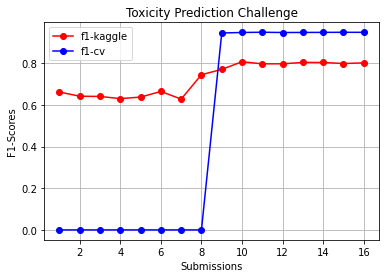

In [133]:
import matplotlib.pyplot as plt

internal = [0,0,0,0,0,0,0,0, 0.9459673027005578, 0.9484676046017727, 0.9495874166080064, 0.9483188330616775, 0.9486082405919692, 0.9490019394762459, 0.9493296698738793, 0.9491389099407354]

f1_scores = [round(x, 5) for x in internal]

kaggle_scores = [0.66247, 0.64216, 0.64119, 0.63063, 0.63819, 0.66521, 0.62836, 0.74568  ,0.77105, 0.80790, 0.79775, 0.79795, 0.80465, 0.80435, 0.79933, 0.80239]

submissions = list(range(1, 17))

plt.xlabel("Submissions")
plt.ylabel("F1-Scores")
plt.title("Toxicity Prediction Challenge")

plt.plot(submissions, kaggle_scores, color='r', label='f1-kaggle', marker= 'o', linestyle = 'solid')
plt.plot(submissions, f1_scores, color='b', label='f1-cv', marker= 'o', linestyle = 'solid')
plt.grid()
plt.legend()
plt.savefig('lb.png', transparent=False)
